In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

In [10]:
account = pd.read_csv('data/account.csv', delimiter=";")
card_test = pd.read_csv('data/card_test.csv', delimiter=";")
card_train = pd.read_csv('data/card_train.csv', delimiter=";")
client = pd.read_csv('data/client.csv', delimiter=";")
disp = pd.read_csv('data/disp.csv', delimiter=";")
district = pd.read_csv('data/district.csv', delimiter=";")
loan_test = pd.read_csv('data/loan_test.csv', delimiter=";")
loan_train = pd.read_csv('data/loan_train.csv', delimiter=";")
trans_test = pd.read_csv('data/trans_test.csv', delimiter=";")
trans_train = pd.read_csv('data/trans_train.csv', delimiter=";")


/home/ricardo/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Account
- account_id
- district_id
- date
- frequency

# Client
- client_id
- birth_number
- district_id

# Disposition
- disp_id
- client_id
- account_id
- type

# Loan
- loan_id
- account_id
- date
- amount
- duration
- payments
- status

# Transition
- trans_id
- account_id
- date
- type
- operation
- amount_balance
- k_symbol
- bank
- account

In [11]:
def renameColumns():
    account.rename({'date': 'account_date', 'district_id': 'account_district_id'}, axis=1, inplace = True)
    client.rename({'district_id': 'client_district_id'}, axis=1, inplace = True)
    loan_train.rename({'date': 'loan_date'}, axis=1, inplace = True)
    loan_test.rename({'date': 'loan_date'}, axis=1, inplace = True)

In [12]:
def getGender(df):
    list = []
    for row in df.itertuples(index = True):
        month = getMonth(row.birth_number)
        birth_number = row.birth_number
        gender = 'M'
        
        if(month > 50):
            birth_number -= 5000
            gender = 'F'
            
        list.append([row.client_id, birth_number, gender, row.client_district_id])
    
    return pd.DataFrame(list, columns=['client_id', 'birth_number', 'gender', 'client_district_id'])

In [13]:
def getMonth(date):
    remove_day = date //100
    month = remove_day % 100
    return month

In [262]:
def getLoansInfo(loan_df, card_df, trans_df):
    client_processed = getGender(client)
    account_date = convertToDate(account, 'account', 'account_date', False)
    client_processed = convertToDate(client_processed,'client','birth_number', False)
    loan_processed = convertToDate(loan_df,'loan_test','loan_date', False).replace({'status': {1: 'successful', -1: 'unsuccessful'}})
    card_processed = card_df.rename({'type': 'card_type'}, axis=1)
    
    trans_processed = convertToDate(trans_df,'trans_train','date', False)[['account_id', 'date', 'balance']]
    trans_processed.sort_values(by = ['account_id', 'date'])
    t = trans_processed.groupby('account_id').tail(1)
    
    merge1 = pd.merge(client_processed, disp[disp['type']=='OWNER'], on ='client_id')
    merge2 = pd.merge(merge1, account_date, on = 'account_id')
    merge3 = pd.merge(merge2, card_processed[['disp_id', 'card_type']], on = 'disp_id', how = 'left')
    merge4 = pd.merge(loan_processed, merge3, on = 'account_id')
    loan_info = pd.merge(merge4, t, on = 'account_id')
    
    loan_info.replace({'status': {1: 'successful', -1: 'unsuccessful'}}, inplace = True)
    loan_info.fillna({'card_type': 'none'}, inplace = True)
    loan_info.drop(['duration', 'payments', 'date', 'disp_id', 'type', 'account_district_id', 'account_date', 'client_id'], axis=1, inplace = True)
    return loan_info

In [225]:
def convertToDate(df, name, column, to_csv):
    new_df = df.copy()
    new_df[column] = 19000000 + new_df[column]
    new_df[column] = pd.to_datetime(new_df[column], format = '%Y%m%d')
    if(to_csv):
        new_df.to_csv('data/processed/' + name + '.csv', index=False)
    return new_df

In [16]:
def processDates(): 
    client_processed = getGender(client)
    convertToDate(account,'account','account_date', True)
    convertToDate(client_processed,'client','birth_number', True)
    convertToDate(loan_test,'loan_test','loan_date', True)
    convertToDate(loan_train,'loan_train','loan_date', True)
    convertToDate(trans_test,'trans_test','date', True)
    convertToDate(trans_train,'trans_train','date', True)


In [264]:
renameColumns()
loans = getLoansInfo(loan_train, card_train, trans_train)
loans_test = getLoansInfo(loan_test, card_test, trans_test)
loans.to_csv('date/processed/loans_')

,loan_id,account_id,loan_date,amount,status,birth_number,gender,client_district_id,frequency,card_type,balance
0,5314,1787,1993-07-05,96396,unsuccessful,1947-07-22,F,30,weekly issuance,none,20100.0
1,5316,1801,1993-07-11,165960,successful,1968-07-22,M,46,monthly issuance,none,52208.9
2,6863,9188,1993-07-28,127080,successful,1936-06-02,M,45,monthly issuance,none,20272.8
3,5325,1843,1993-08-03,105804,successful,1940-04-20,F,14,monthly issuance,none,34292.7
4,7240,11013,1993-09-06,274740,successful,1978-09-07,M,63,weekly issuance,none,41142.9
...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,1996-12-12,155616,successful,1971-04-10,F,72,monthly issuance,none,60694.1
324,5625,3189,1996-12-15,222180,unsuccessful,1939-03-20,M,29,monthly issuance,none,59578.8
325,6805,8972,1996-12-21,45024,successful,1957-05-04,F,70,monthly issuance,none,38384.3
326,7233,10963,1996-12-25,115812,successful,1953-06-01,M,16,monthly issuance,none,41878.1


In [232]:
loan_test

,loan_id,account_id,loan_date,amount,duration,payments,status
0,5895,4473,970103,93960,60,1566,NaN
1,7122,10365,970104,260640,36,7240,NaN
2,6173,5724,970108,232560,48,4845,NaN
3,6142,5591,970121,221880,60,3698,NaN
4,5358,2018,970121,38520,12,3210,NaN
...,...,...,...,...,...,...,...
349,4989,105,981205,352704,48,7348,NaN
350,5221,1284,981205,52512,12,4376,NaN
351,6402,6922,981206,139488,24,5812,NaN
352,5346,1928,981206,55632,24,2318,NaN


In [253]:
l = convertToDate(loan_test,'loan_test','loan_date', False)
t = convertToDate(trans_test,'trans_test','date', False)[['account_id', 'date', 'balance']]
r = pd.merge(l, t, on='account_id')
#r[(r['loan_id'] == 5314) & (max(r['date']))]
t[t['account_id'] == 4473]

,account_id,date,balance
12821,4473,1995-10-09,800.0
12822,4473,1995-11-07,25225.0
12823,4473,1995-11-08,25725.0
12824,4473,1995-11-30,25807.2
12825,4473,1995-12-07,62444.7
...,...,...,...
12905,4473,1996-12-07,73635.1
12906,4473,1996-12-11,68990.1
12907,4473,1996-12-31,69263.1
12908,4473,1996-12-31,69248.5


# Applying Algorithms












In [76]:
from sklearn.preprocessing import LabelEncoder

df = loans.copy()
for f in df.columns:
    if df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

X= df.drop(columns='status')
y = df['status'].copy()

df_test = loans_test.copy()

for f in df_test.columns:
    if df_test[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(df_test[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))

X_test = df_test.drop(columns='status')
y_test = df_test['status'].copy()


In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#	test_size = 0.30, random_state = 0)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold

def find_best_params_kfold(model, X, y, param_grid, n_iter=10, n_splits=3):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    search = RandomizedSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, n_iter=n_iter, cv=kfold, verbose=0, random_state=0)
    result = search.fit(X, y)
    
    report(result.cv_results_)

In [ ]:
def report(results, n_top=3):
    res = []
    res_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            res.append([np.multiply(results['mean_test_score'][candidate], -1), 
                        results['std_test_score'][candidate]])
            for key in results['params'][candidate].keys():
                res[res_i].append(results['params'][candidate][key])
            res_i+=1
    
    columns = ['Mean absolute error', 'std'] + list(results['params'][candidate].keys())
    display(pd.DataFrame(res, columns=columns))

In [ ]:
def cross_validationScores(modelName, model, X, y, n_folds=10):
    metrics = {'MAE': 'neg_mean_absolute_error', 
               'RMSE': 'neg_root_mean_squared_error'}
    
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    scores = cross_validate(model, X, y, cv=kfold, scoring=metrics, n_jobs=-1)

    # multiply by -1 because sklearn scoring metrics are negative
    mean_mae_score = np.multiply(scores['test_MAE'], -1).mean()
    std_mae_score = np.multiply(scores['test_MAE'], -1).std()
    mean_rmse_score = np.multiply(scores['test_RMSE'], -1).mean()
    std_rmse_score = np.multiply(scores['test_RMSE'], -1).std()

    model_score = pd.DataFrame([[mean_mae_score, mean_rmse_score]], 
                             columns=['MAE', 'RMSE'], index=[modelName])
    global models_mean_scores
    models_mean_scores = models_mean_scores.append(model_score)

    print(str(n_folds) + " fold Cross validation scores for " + modelName)
    score_df = pd.DataFrame([[mean_mae_score, std_mae_score], 
                                  [mean_rmse_score, std_rmse_score]], 
                                 columns=['Mean score', 'std'], 
                                 index=['MAE', 'RMSE'])
    display(score_df)

In [ ]:
#from sklearn import tree

#X_train = df.drop(columns='status')
#y_train = loan['status'].copy()
#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(X, y)

#X_test = loan_test.drop(columns='status')
#y_test = clf.predict(X_test)

In [ ]:
predict_loan = {'Id': X_test["loan_id"], 'Predicted': y_test}
df = pd.DataFrame(data=predict_loan)
df.to_csv('loan_predict.csv', index=False)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

max_depth = range(2, 30, 1)
min_samples_split = range(1, 10, 1)

param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split)

find_best_params_kfold(DecisionTreeClassifier(random_state=0), X, y, param_grid, 
                       n_iter=50, n_splits=10)

In [ ]:
classifier_cart = DecisionTreeClassifier(max_depth=2, min_samples_split=9, random_state=0)
classifier_cart = classifier_cart.fit(X, y)

y_test_cart = classifier_cart.predict(X_test)

#df_pred = pd.DataFrame(data={'Id': X_test["loan_id"], 'Predicted': y_test_cart})
#df_pred.to_csv('loan_pred_1.csv', index=False)

In [ ]:
y_test_cart = classifier_cart.predict(X_test)
#df_pred = pd.DataFrame(data={'Id': X_test_owner["loan_id"], 'Predicted': y_test_cart})
#df_pred.to_csv('loan_pred_3.csv', index=False)
y_test_cart

In [ ]:
from sklearn.ensemble import BaggingClassifier
n_estimators = range(50, 1000, 50)
param_grid = dict(n_estimators=n_estimators)

find_best_params_kfold(BaggingClassifier(base_estimator=regr_cart,
                                        n_jobs=-1, random_state=0), 
                       X, y, param_grid, n_iter=30, n_splits=3)

In [ ]:
X_test_owner = X_test[X_test['type']==1]

In [ ]:
loan_train

In [ ]:
df_owner = df[df['type']==1]
df_owner = df_owner[['loan_id', 'loan_date', 'account_date', 'amount', 'duration', 'payments', 'account_district_id', 'client_district_id', 'status']]
X= df_owner.drop(columns='status')
y = df_owner['status'].copy()
X_test = X_test[['loan_id', 'loan_date', 'account_date', 'amount', 'duration', 'payments', 'account_district_id', 'client_district_id']]

NameError: name 'df' is not defined

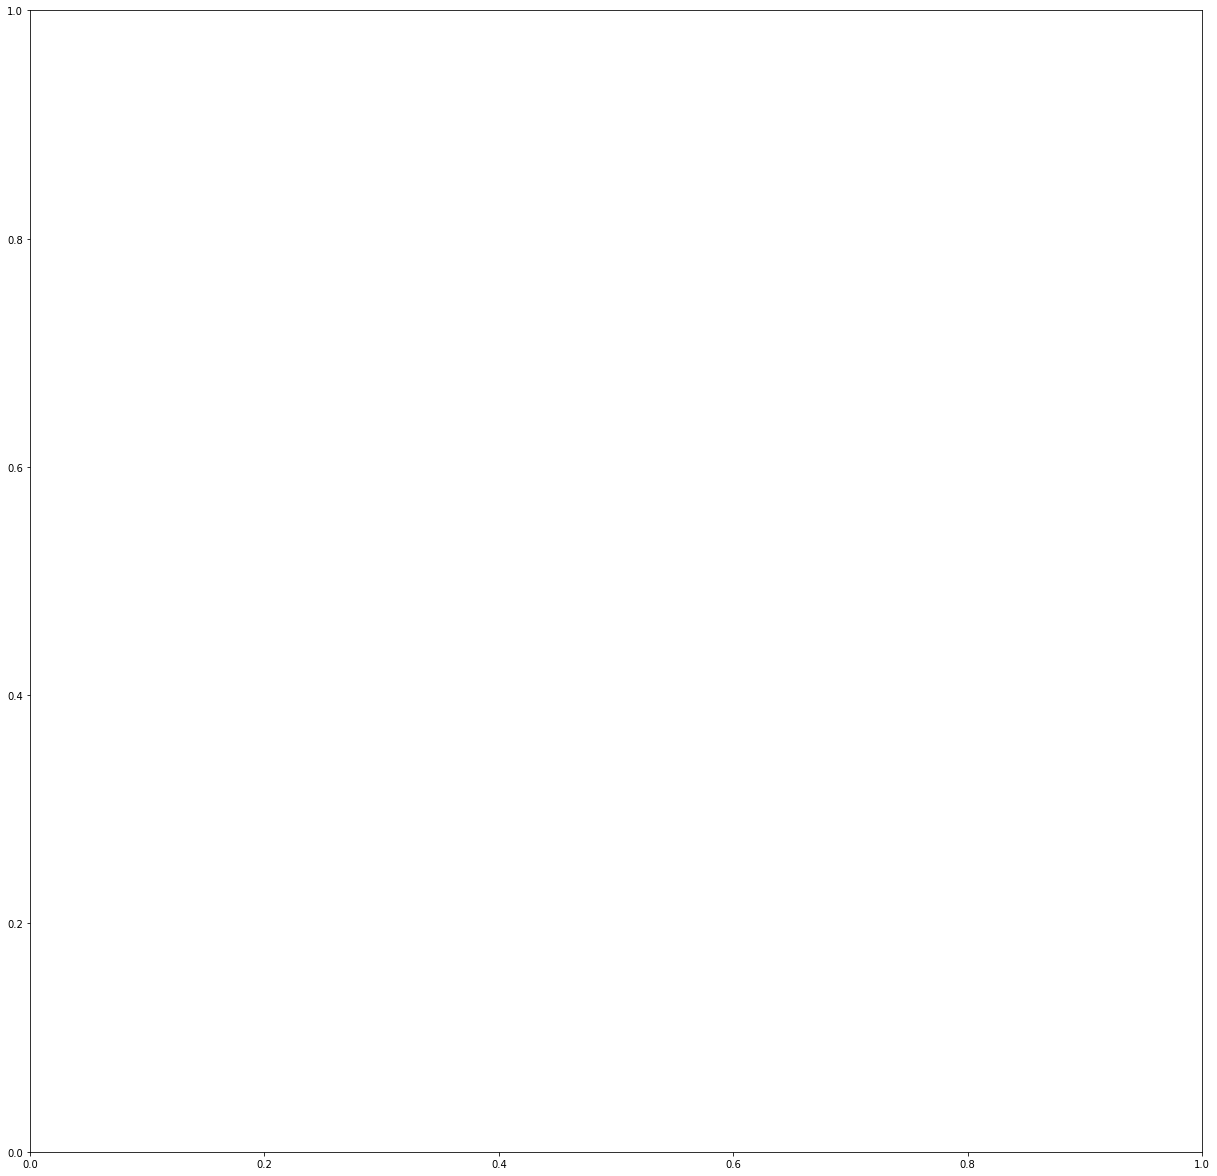

In [111]:
ax = plt.subplots(figsize=(21, 21))
ax = sns.heatmap(df.corr(), annot= True)

In [ ]:
df_owner